In [1]:
import os 
import sys 
import glob 
import pandas as pd 
import numpy as np 
import rasterio as rio
import geopandas as gpd 
import subprocess
from rasterstats import zonal_stats, point_query


In [2]:
data_summary_path = '/nfs/attic/dfh/data/snodas/dailyclim/'
data_path = '/nfs/attic/dfh/data/snodas/snodas_download/'#yyyy/dd-mmm/Hs/
cso_data_path = '/nfs/attic/dfh/Aragon2/snow_change_from_dave/cso-data.geojson'
comp_matlab = '/nfs/attic/dfh/Aragon2/snow_change_from_dave/datacompare.csv'


In [42]:
csodf = gpd.read_file(cso_data_path)
#csodf['dt'] = pd.to_datetime(csodf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
#csodf = csodf[0:5]
csodf

,id,author,depth,source,timestamp,elevation,_ms,geometry,dt
0,uW1g0dAo,James Molloy,190.0,MountainHub,2019-04-13T02:25:06.435000+00:00,2936.050537,1555122306435,POINT (-110.06545 43.75285),2019-04-13 02:25:06.435000+00:00
1,su7tnS0Q,Brooks Taylor,118.0,MountainHub,2019-01-20T20:45:35.390999+00:00,2322.340088,1548017135391,POINT (-110.68357 44.05567),2019-01-20 20:45:35.390999+00:00
2,oLinNVH0,Brooks Taylor,110.0,MountainHub,2019-01-20T17:30:22.802000+00:00,2313.090332,1548005422802,POINT (-110.68245 44.05640),2019-01-20 17:30:22.802000+00:00
3,o9KCw9be,James Molloy,187.0,MountainHub,2019-01-12T19:52:14.262000+00:00,2588.510742,1547322734262,POINT (-110.78295 43.71575),2019-01-12 19:52:14.262000+00:00
4,42FrqUY+,James Molloy,208.0,MountainHub,2019-03-03T22:15:10.107000+00:00,2246.562988,1551651310107,POINT (-110.76157 43.71568),2019-03-03 22:15:10.107000+00:00
...,...,...,...,...,...,...,...,...,...
223,+cHuTfsk,Celine Jaccard,150.0,SnowPilot,2019-01-22T08:10:00+00:00,2436.658203,1548144600000,POINT (-110.95320 43.48429),2019-01-22 08:10:00+00:00
224,DymAudqU,Sam Rogers,170.0,SnowPilot,2019-02-01T20:40:00+00:00,2516.089355,1549053600000,POINT (-110.95953 43.48326),2019-02-01 20:40:00+00:00
225,UMUVMTlQ,Mark Staples,147.0,SnowPilot,2019-02-08T09:00:00+00:00,2805.057129,1549616400000,POINT (-112.40497 38.20270),2019-02-08 09:00:00+00:00
226,WoX30vJN,Drew Nehrenz,66.0,SnowPilot,2019-01-19T22:00:00+00:00,2870.665527,1547935200000,POINT (-112.34843 38.32089),2019-01-19 22:00:00+00:00


In [50]:
data =[]
min_data = []
max_data = []
mean_data = []

# make temp directory for tif files
tmp_dir = 'tmp_downloads/'
subprocess.call(f'mkdir -p {tmp_dir}',shell=True)
    
# loop to get SNOTEL data at each CSO obs
for i in range(len(csodf)):
    print(i)
    # get date
    date = pd.to_datetime(csodf.timestamp[i], format='%Y-%m-%dT%H:%M:%S')
    
    # define path names
    hdr_base_path = '/nfs/attic/dfh/data/snodas/snodas_download/snodas_base_header.hdr'
    Fname = '/nfs/attic/dfh/data/snodas/snodas_download/'+date.strftime("%Y")+'/'+date.strftime("%m")+'_'+date.strftime("%b")+'/Hs/us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.dat'
    HDRname = '/nfs/attic/dfh/data/snodas/snodas_download/'+date.strftime("%Y")+'/'+date.strftime("%m")+'_'+date.strftime("%b")+'/Hs/us_ssmv11036tS__T0001TTNATS'+date.strftime("%Y")+date.strftime("%m")+date.strftime("%d")+'05HP001.hdr'
    min_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036min.dat'
    min_HDRname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036min.hdr'
    max_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036max.dat'
    max_HDRname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036max.hdr'
    mean_Fname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036mean.dat'
    mean_HDRname = '/nfs/attic/dfh/data/snodas/dailyclim/'+date.strftime("%m")+date.strftime("%d")+'1036mean.hdr'

    #create temporary hdr files 
    subprocess.call(f'cp {hdr_base_path} {HDRname}',shell=True)
    subprocess.call(f'cp {hdr_base_path} {min_HDRname}',shell=True)
    subprocess.call(f'cp {hdr_base_path} {max_HDRname}',shell=True)
    subprocess.call(f'cp {hdr_base_path} {mean_HDRname}',shell=True)

    # create temporary .tif
    output_tif = tmp_dir+'data.tif'
    cmd = f'gdal_translate -of GTiff -a_srs "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs" -a_nodata -9999 -a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000 {Fname} {output_tif}'
    subprocess.call(cmd, shell=True)
    #extract point value
    pts = point_query([csodf.geometry[i]], output_tif)
    data.append(pts[0])
    
    # create temporary min .tif
    output_tif = tmp_dir+'min_data.tif'
    cmd = f'gdal_translate -of GTiff -a_srs "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs" -a_nodata -9999 -a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000 {Fname} {output_tif}'
    subprocess.call(cmd, shell=True)
    #extract point value
    pts = point_query([csodf.geometry[i]], output_tif)
    min_data.append(pts[0])
    
    # create temporary max .tif
    output_tif = tmp_dir+'max_data.tif'
    cmd = f'gdal_translate -of GTiff -a_srs "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs" -a_nodata -9999 -a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000 {Fname} {output_tif}'
    subprocess.call(cmd, shell=True)
    #extract point value
    pts = point_query([csodf.geometry[i]], output_tif)
    max_data.append(pts[0])
    
    # create temporary mean .tif
    output_tif = tmp_dir+'mean_data.tif'
    cmd = f'gdal_translate -of GTiff -a_srs "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs" -a_nodata -9999 -a_ullr -124.73333333333333 52.87500000000000 -66.94166666666667 24.95000000000000 {Fname} {output_tif}'
    subprocess.call(cmd, shell=True)
    #extract point value
    pts = point_query([csodf.geometry[i]], output_tif)
    mean_data.append(pts[0])
    
    #remove temporary files 
    subprocess.call(f'rm {HDRname}',shell=True)
    subprocess.call(f'rm {min_HDRname}',shell=True)
    subprocess.call(f'rm {max_HDRname}',shell=True)
    subprocess.call(f'rm {mean_HDRname}',shell=True)
subprocess.call(f'rm -rf {tmp_dir}',shell=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227


0

In [52]:
csodf['snodas_hs'] = data
csodf['snodas_min'] = min_data
csodf['snodas_max'] = max_data
csodf['snodas_mean'] = mean_data

(0.0, 5000.0)

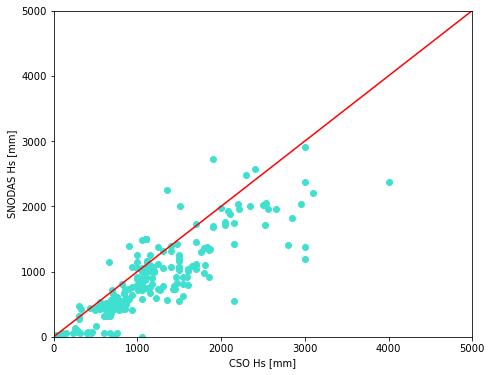

In [70]:
import matplotlib.pyplot as plt
# create data
x = csodf.depth*10
y = csodf.snodas_hs

plt.figure(1, figsize=[7.5,6])
plt.plot(np.arange(0,5000), np.arange(0,5000),'r')
plt.scatter(x, y,c='turquoise')
plt.ylabel('SNODAS Hs [mm]')
plt.ylim([0,5000])
plt.xlabel('CSO Hs [mm]')
plt.xlim([0,5000])

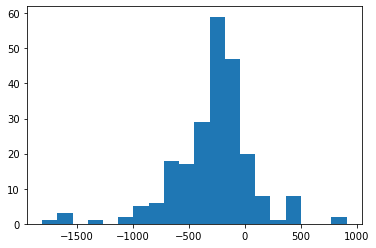

In [74]:
fig, axs = plt.subplots(1)  
data = csodf.snodas_hs - csodf.depth.values*10
axs.hist(data,bins=20);

In [76]:
# save geojson
out = 'CSO_SNODAS.geojson'
csodf.to_file(out, driver='GeoJSON')

In [23]:

stats = zonal_stats(cso_data_path, output_tif)
pts = point_query(cso_data_path, output_tif)

